# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [866]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import scipy.stats as st
import pymc3 as mc

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

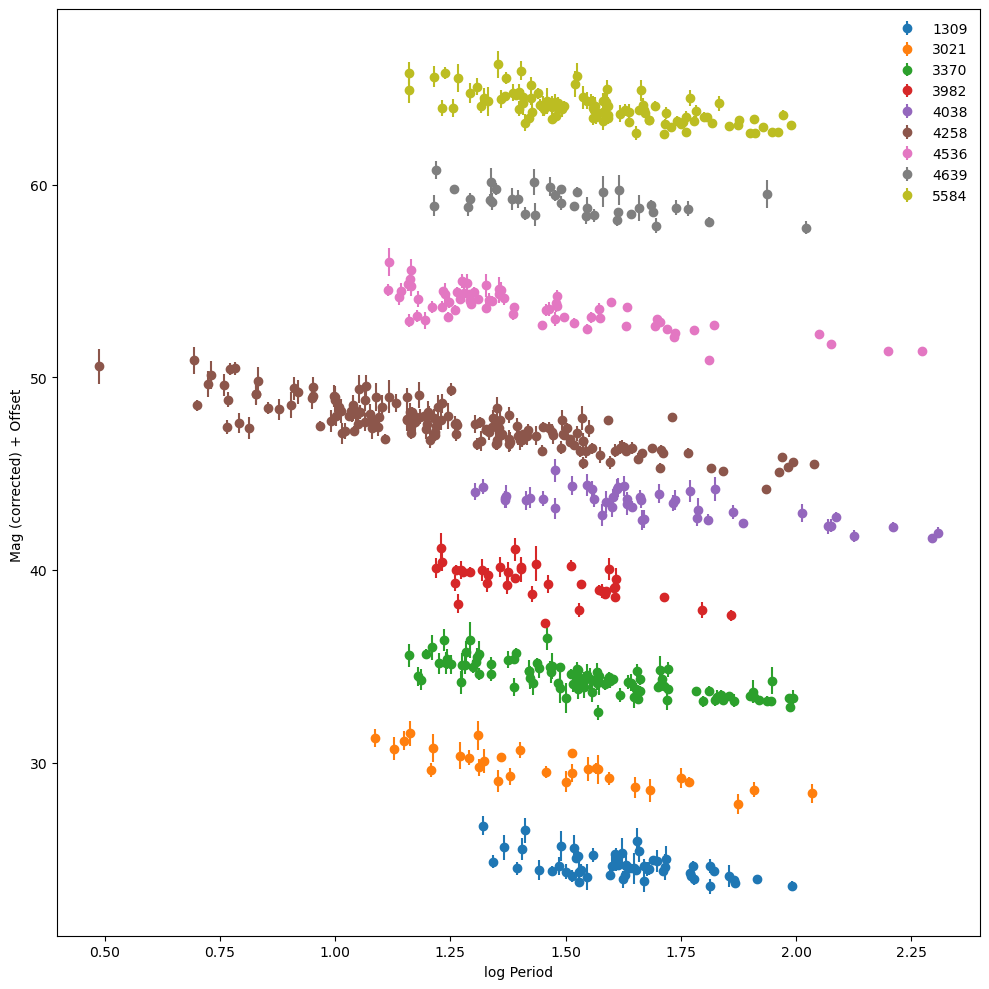

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


---

The equation in question (Eq 1 from Riess et al. 2011),

$$ \large m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258} + b_W \log P_{i,j}$$

Where,

- $ m_{W,i,j}$ is the magnitude observed
- $(\mu_{0,i} - \mu_{0,4258})$ are the Reddening Free Distances for the hosts relative to NGC 4258 
- $z p_{W,4258}$ is the intercept of the P–L relation simultaneously fit to the Cepheids of NGC 4258 
    - The [P-L relation](https://en.wikipedia.org/wiki/Period-luminosity_relation)
- $b_W \log P_{i,j}$ is the nuisance parameter $b$ multiplied by the log of the period 

From `cepheids.py`

```python
def negative_log_likelihood(self, theta):
        """
        Computes -log L(theta)

        Parameters
        ----------
        theta : float, ndarray
            parameters being fitted, (a,b)

        Returns
        -------
        0.5 * chisq
        """
        a, b = theta[0], theta[1]
        chisq = np.sum(((self.mobs - a * self.logP - b) / self.sigma)**2)
        return 0.5 * chisq
```

So it should be,

$$ \sum \left(\frac{m_\text{obs} - a \log P -b}{\sigma}\right)^2$$

Thus, where $n$ is the number of Cepheids ($j$) per $i^\text{th}$ Galaxy and $N$ is the number of galaxies,

$$-\chi^2 =\sum_{i=1}^{N} \sum_{j=1}^n \left(\frac{m_{W,i,j} - b_W \log P_{i,j} -((\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258})}{\sigma_j}\right)^2$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

---
<!-- I don't know buddy... trying to figure out a prior for $\alpha$ where $\alpha = (\mu_{0,i} - \mu_{0,4258}) + z p_{W,4258}$ -->

<!-- - 0.5 to 10 -->

For $b_W$ we can assume a negative number via Homework #1 and magnitudes from -0.5 to -10 in a uniform distribution since it shoudn't need to vary by much since one can see from the plot above that it is not a large slope to be fit.

For $(\mu_{0,i} - \mu_{0,4258})$ we can find a good prior from taking the two equations from the distance modulus and putting it in terms of their redshifts that we know thus,

$$m-M=5\log_{10}(d)-5$$

$$\mu_{0,i} - \mu_{0,4258} = 5\log_{10}\left(\frac{d_i}{d_{4258}}\right)$$

where $d = \frac{cz}{H_0}$ thus,

$$\mu_{0,i} - \mu_{0,4258} = 5\log_{10}\left(\frac{z_i}{z_{4258}}\right)$$

We can use this value as the location for a normal distribution and set the scale to 1 to keep the variance down.

For $ z p_{W,4258}$, we do an initial fit of the galaxy n4258 cepheid data using `np.polyfit()` to find an intercept and we use this estimate and vary around it by 1 sigma in a normal distribution. 



In [752]:
#Fitting for the prior on zp_W
ceph.select('4258')
zpwg=np.polyfit(ceph.logP,ceph.mobs,1)[1]

In [276]:
np.polyfit(ceph.logP,ceph.mobs,1)

array([-3.2851689 , 26.71641532])

In [592]:
sig1 = rz = np.zeros(len(hosts)) # redshifts and sigmas

for i in range(len(hosts)):
    ceph.select(hosts[i])
    sig1[i] = np.std(ceph.mobs)
    rz[i] = ceph.redshifts[hosts[i]]

In [1009]:
#FASTER VERSION
def logPriorFAST(theta):
    z42 = ceph.redshifts['4258']
    ret=np.zeros_like(theta)
    assert len(rz)==len(theta)-1
    assert len(sig1)==len(theta)-1
        
        # ceph.select(hosts[i])
    val=st.norm.pdf(theta[:-1],loc=5*np.log10(rz/z42),scale=1)
    ret[:-1]=np.log(val)
        # ret.append(val)
    ceph.select('4258')
    # ret[-1]=st.norm.pdf(theta[-1],loc=zpwg,scale=np.std(ceph.mobs)*5)
    # if theta[:-2][hosts=='4258']>= 0.25 or theta[:-2][hosts=='4258']<=-0.25:
    #     ret[:-2][hosts=='4258']=-np.inf
    # else:
    ret[:-1][hosts=='4258'] = np.log(st.norm.pdf(theta[-1],loc=zpwg,scale=1))
    if theta[-1]<= -8 or theta[-1]>=-0.5:
        ret[-1]=-np.inf
    else:
        ret[-1]=0
    return np.sum(ret)

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [854]:
def LogPosterior(theta):
    cs=[]
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        if ID=='4258':
            wack = [theta[-1],0+theta[i]]
        else:
            wack = [theta[-1],theta[i]+theta[:-1][hosts=='4258']]
        cs.append(-ceph.negative_log_likelihood(wack))
    lnlike = np.sum(cs)
    lnprior=logPriorFAST(theta)
    return lnlike+lnprior
    

In [1010]:
ndim=len(hosts)+1 #number of hosts plus b_W and zpW
nwalkers=20
def guess(ndim,nwalkers):
    ig=np.zeros((nwalkers,ndim))
    for i in range(len(hosts)):
        ceph.select(hosts[i])
        z42 = ceph.redshifts['4258']
        val=st.norm.rvs(loc=5*np.log10(ceph.redshifts[hosts[i]]/z42),scale=1,size=nwalkers)
        ig[:,i]=val
        if hosts[i]=='4258':
            # ig[:,i]=st.norm.rvs(loc=0,scale=0.1,size=nwalkers)
            ig[:,i]=st.norm.rvs(loc=zpwg,scale=1,size=nwalkers)
    ig[:,-1]= np.random.uniform(-6,-0.5,(nwalkers))
    # ig[:,-1]=st.norm.rvs(loc=zpwg,scale=np.std(ceph.mobs)*5,size=nwalkers)
    return ig
# ig=np.zeros((nwalkers,len(hosts)+1))
# ig[:,np.arange(len(hosts))]=np.random.uniform(0.5,30,(nwalkers,len(hosts)))
# ig[:,-1] = np.random.uniform(-6,-0.5,(nwalkers))

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:47<00:00, 59.68it/s]


CPU times: user 1min 31s, sys: 359 ms, total: 1min 31s
Wall time: 3min 7s


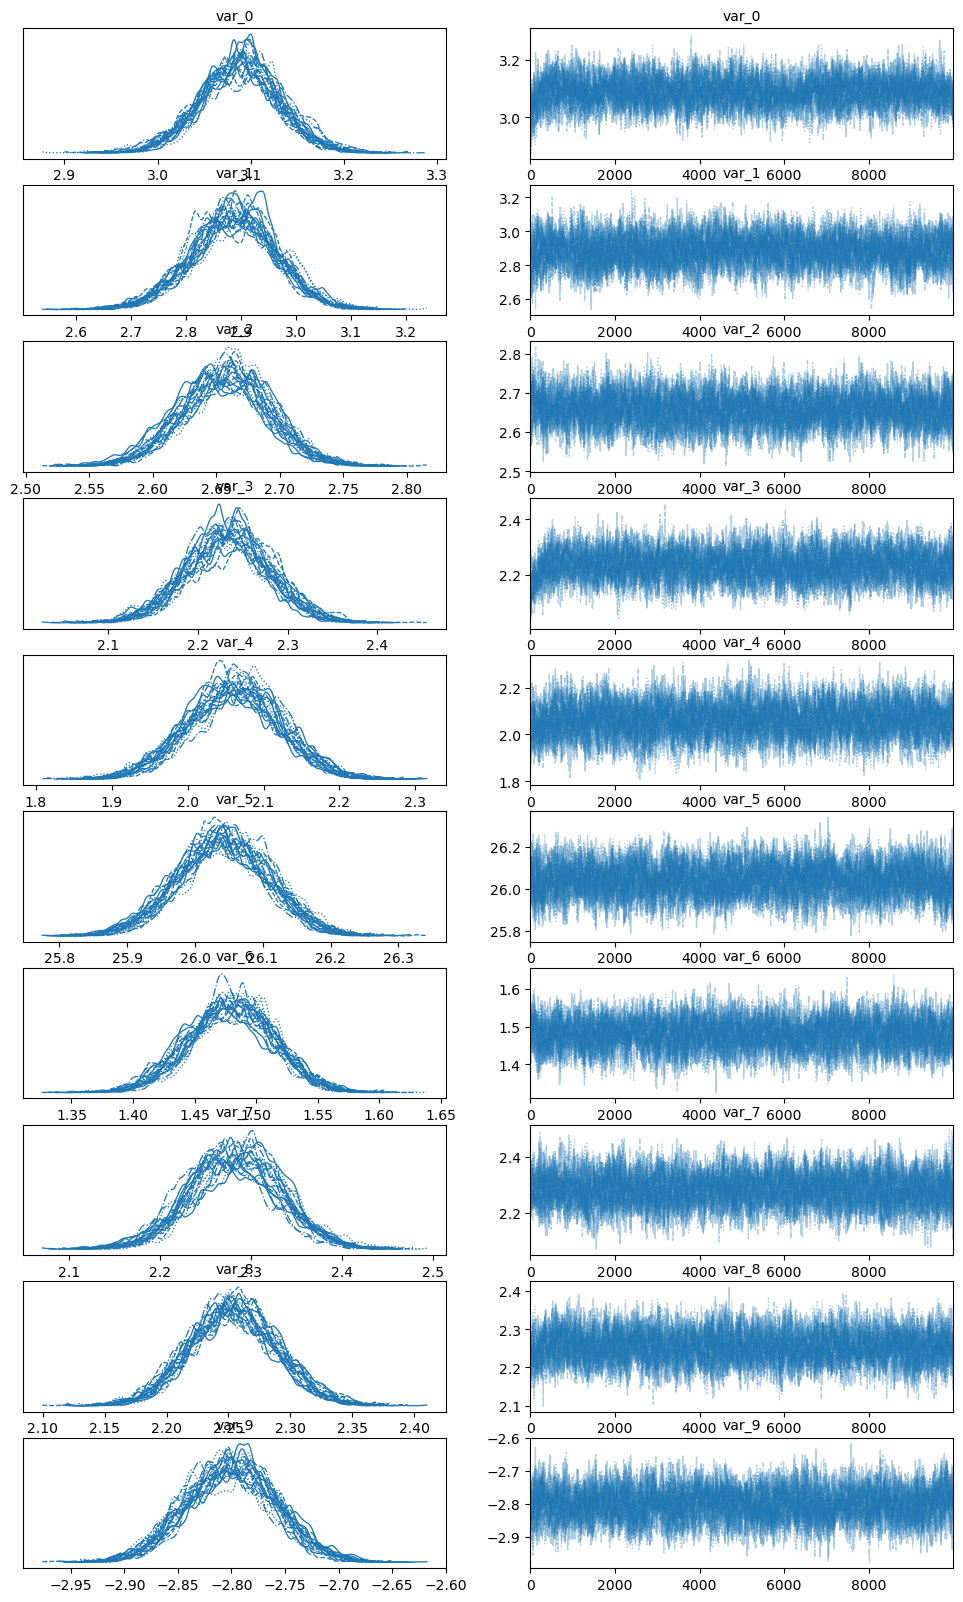

In [1011]:
%%time
ig=guess(ndim,nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
state = sampler.run_mcmc(ig, 1000,progress=True) # burn-in
sampler.reset()                  
samp=sampler.run_mcmc(state,10_000,progress=True);
mc.plot_trace(sampler);
sam=sampler.get_chain(flat=True)

**NOTE:** I do not know how to get the variable names to show up in the traceplot above.

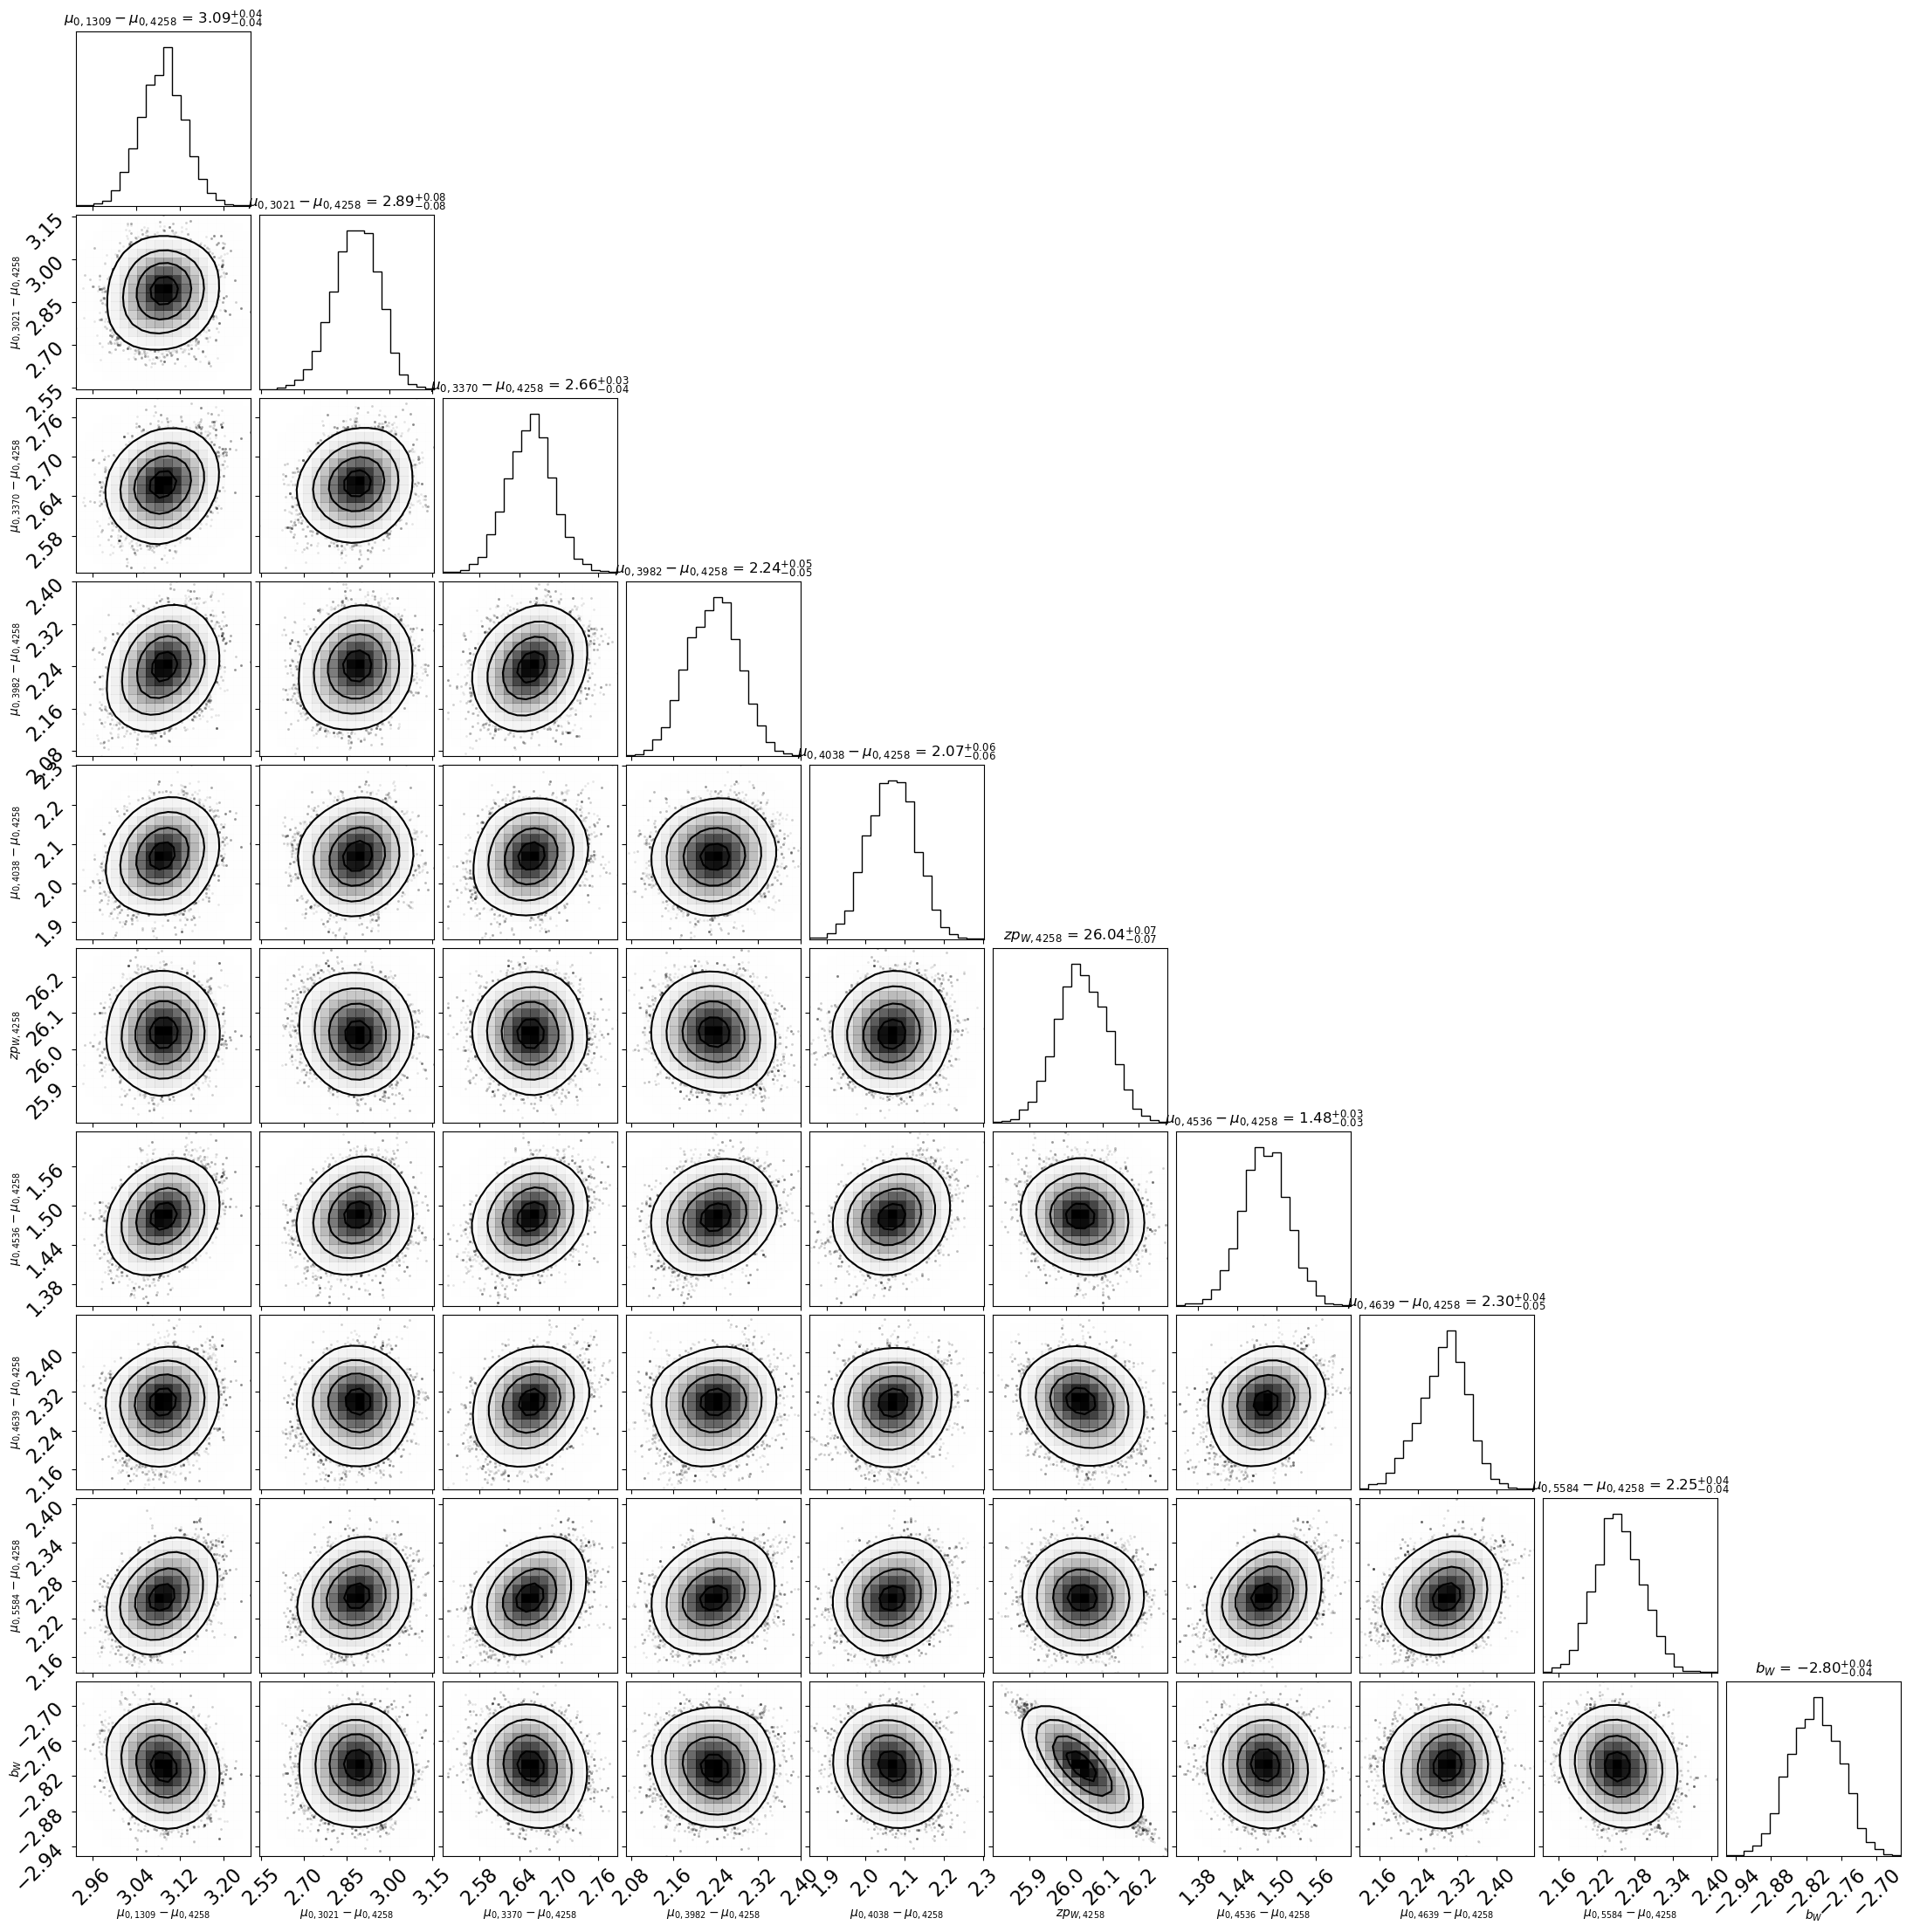

In [1043]:
labels=[]
for i in range(len(hosts)): labels.append(r"$\mu_{0,"+hosts[i]+"} - \mu_{0,4258}$")
labels.append(r"$b_W$")
labels[5]=r'$z p_{W,4258}$'
# labels.append('z')
corner.corner(sam[::10,:], plot_contours=True, show_titles=True, smooth=2,labels=labels);
# plt.savefig('crispy.png')

In [95]:
def func(x,m,b):
    return m*x+b

In [759]:
med =np.median(sam[::],axis=0)
mcmc_res = np.percentile(sam[::,:], [50, 16, 84], axis=0)

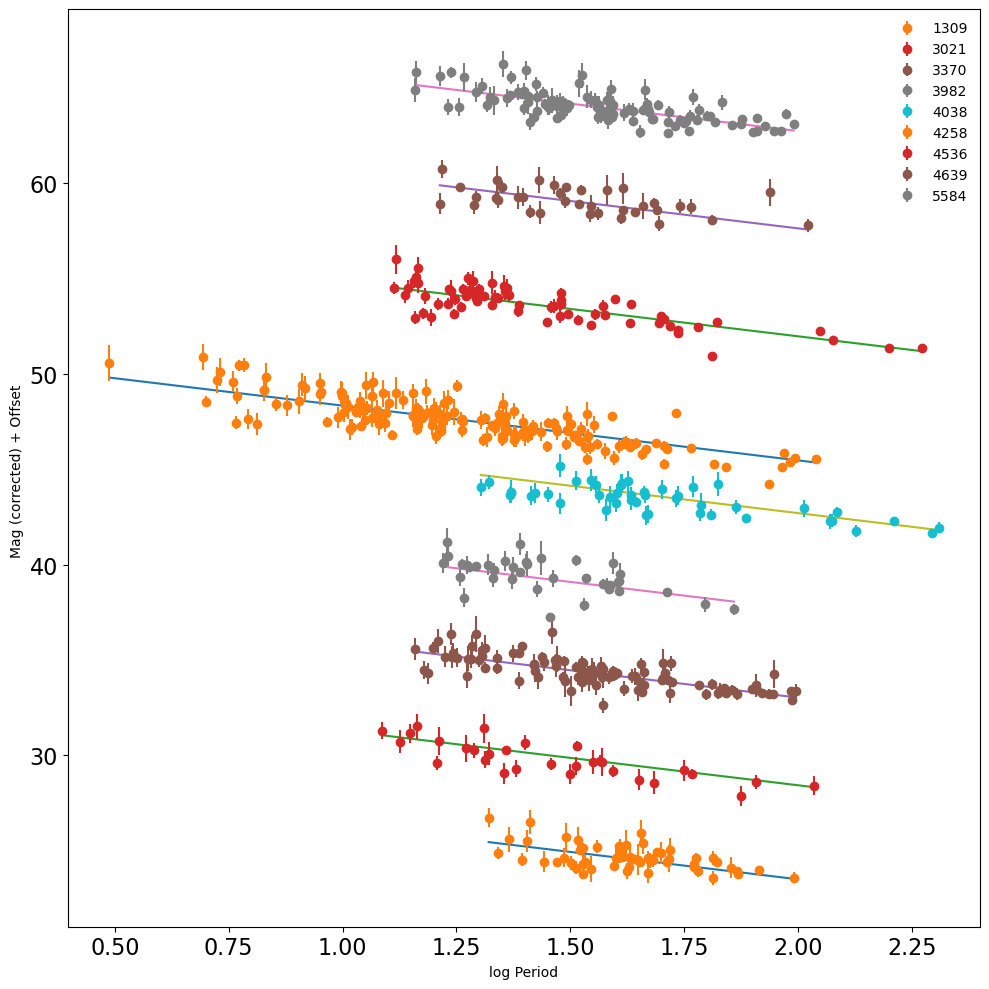

In [760]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    xv=np.linspace(logP.min(),logP.max(),1000)
    ax.plot(xv,(5*i)+func(xv,med[-2],med[i]+med[-1]))
    ax.errorbar(logP, mobs+(i*5), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

The dashed lines are the 16th and 84th percentiles from the flattened chain.

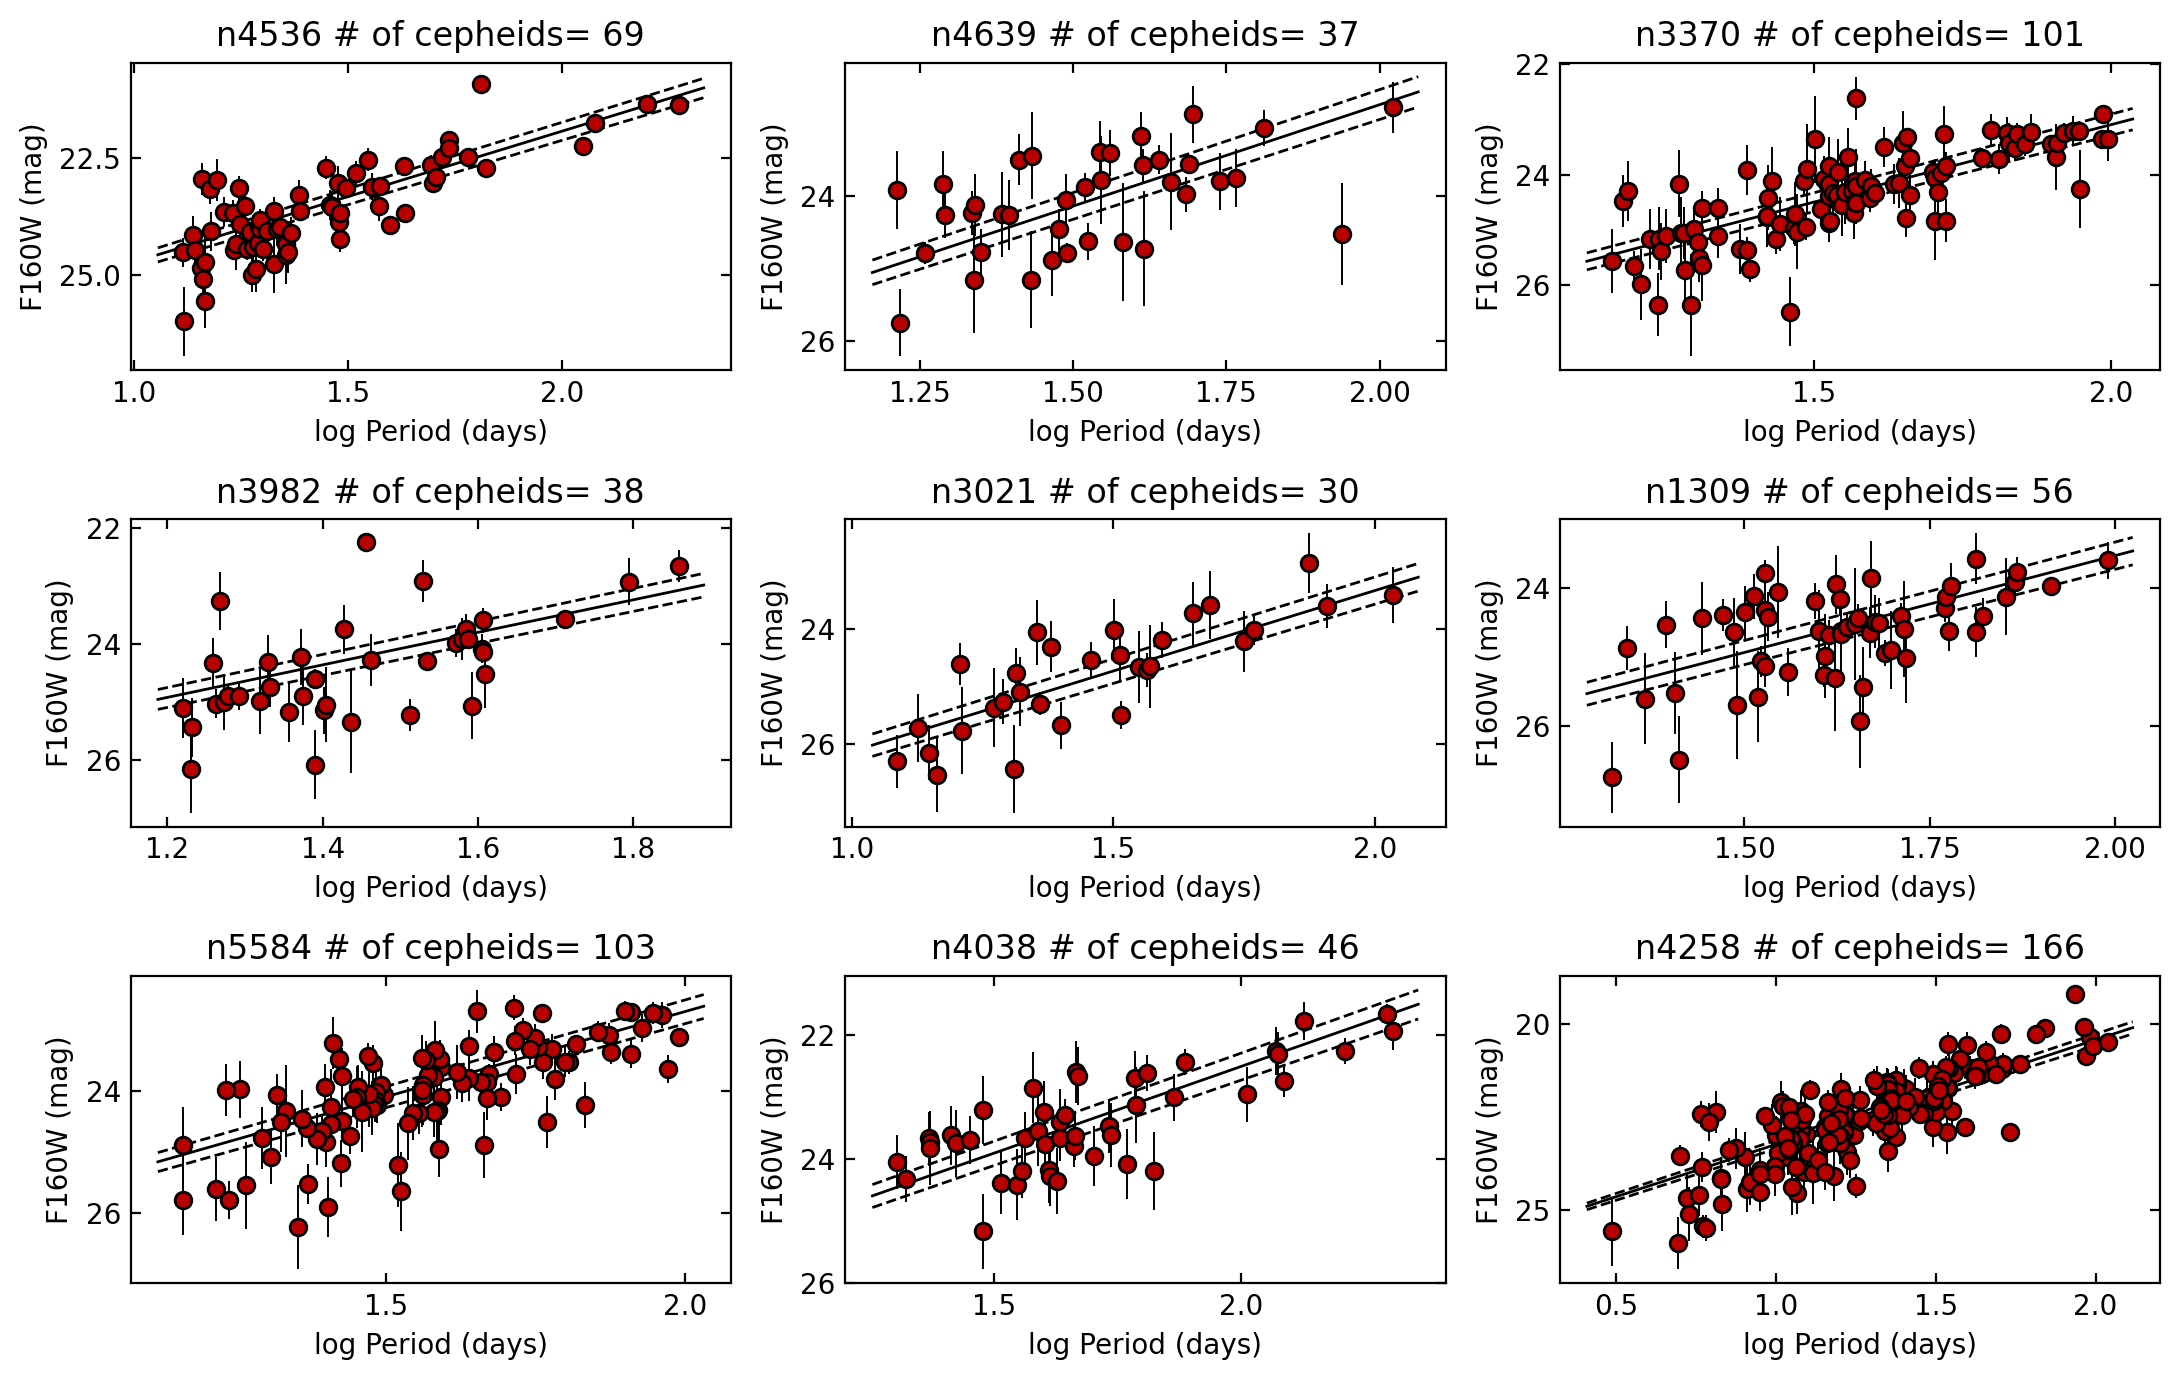

In [1040]:
order=['4536','4639','3370','3982','3021','1309','5584','4038','4258']
# plt.rcParams["font.family"] = "sans serif"
plt.figure(figsize=(11,7),dpi=200,layout='tight')
# plt.
i=0
gals = np.percentile(sam[::10,:],[16,50,84],axis=0)
med=gals[1]
for rog in order:
    plt.subplot(331+i)
    ceph.select(rog)
    logP=ceph.logP
    sigma_obs = ceph.sigma
    mobs = ceph.mobs
    plt.tick_params(axis='both',which='both',top=True,right=True,direction='in')
    
    m2 = med[:-1]
    plt.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', 
                 marker='o',markeredgecolor='k', label=rog,
                 color='#b90000',ecolor='k',elinewidth=0.7)
    l,r=plt.xlim()
    xv=np.linspace(l,r,1000)
    if rog=='4258':
        plt.plot(xv,func(xv,med[-1],med[5]),c='k',lw=1)
        plt.plot(xv,func(xv,gals[0,-1],gals[0,5]),c='k',lw=1,ls='--')
        plt.plot(xv,func(xv,gals[-1,-1],gals[-1,5]),c='k',lw=1,ls='--')
    else:
        plt.plot(xv,func(xv,med[-1],m2[hosts==rog]+med[5]),c='k',lw=1)
        plt.plot(xv,func(xv,gals[0,-1],gals[0,:-1][hosts==rog]+gals[0,5]),c='k',lw=1,ls='--')
        plt.plot(xv,func(xv,gals[-1,-1],gals[-1,:-1][hosts==rog]+gals[-1,5]),c='k',lw=1,ls='--')
    plt.title(f"n{rog} # of cepheids= {len(mobs)}")
    plt.ylabel('F160W (mag)')
    plt.xlabel('log Period (days)')
    plt.xticks(fontsize='medium')
    plt.yticks(fontsize='medium')
    up,d = plt.ylim()
    plt.ylim(d,up)
    i=i+1

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

Table 3 of Riess,

|Host| SN Ia| Filters| m0v,i + 5av| σ a| µ0,i − µ0,4258 |µ0 best|
|:---:|:---:|:------:|:----------:|:--:|:--------------:|:-----:|
n4536| SN 1981B |UBV R |15.147 |0.145 |1.567 (0.0404) |30.91 (0.07)
n4639 |SN 1990N |UBV RI |16.040 |0.111 |2.383 (0.0630) |31.67 (0.08)
n3370 |SN 1994ae |UBV RI |16.545 |0.101 |2.835 (0.0284) |32.13 (0.07)
n3982 |SN 1998aq |UBV RI |15.953 |0.091 |2.475 (0.0460) |31.70 (0.08)
n3021 |SN 1995al |UBV RI |16.699 |0.113 |3.138 (0.0870) |32.27 (0.08)
n1309 |SN 2002fk |BV RI |16.768 |0.103 |3.276 (0.0491) |32.59 (0.09)
n5584 |SN 2007af |BV RI |16.274 |0.122 |2.461 (0.0401) |31.72 (0.07)
n4038 |SN 2007sr |BV RI |15.901 |0.137 |2.396 (0.0567)| 31.66 (0.08)

In [1039]:
bruh=sam[::,:-1]
bruh = bruh[:,hosts!='4258']
bruh = np.median(bruh,axis=0)
print('ID   Modulus')
for i in range(len(bruh)):
    print(hosts[hosts!='4258'][i],bruh[i])

ID   Modulus
1309 3.0889006570013358
3021 2.8882062439368004
3370 2.6581526829923394
3982 2.234410237313233
4038 2.0617311992984364
4536 1.4801078533395982
4639 2.283559425217644
5584 2.253740393927065


# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation 3,

$$\large m_{v,i}^0 = (\mu_{0,i} - \mu_{0,4258})+ m_{v,4258}^0$$

Equation 4,

$$\large \log H_0 = \frac{(m_{v,4258}^0- \mu_{0,4258})+5 a_v +25}{5}$$

Thus,

$$\large \log H_0 = \frac{(m_{v,i}^0 -(\mu_{0,i} - \mu_{0,4258})- \mu_{0,4258})+5 a_v +25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

From [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) $d_{4258} = 7.6 \; \text{Mpc}$

|Host| SN Ia| Filters| m0v,i + 5av| σ a| µ0,i − µ0,4258 |µ0 best|
|:---:|:---:|:------:|:----------:|:--:|:--------------:|:-----:|
n4536| SN 1981B |UBV R |15.147 |0.145 |1.567 (0.0404) |30.91 (0.07)
n4639 |SN 1990N |UBV RI |16.040 |0.111 |2.383 (0.0630) |31.67 (0.08)
n3370 |SN 1994ae |UBV RI |16.545 |0.101 |2.835 (0.0284) |32.13 (0.07)
n3982 |SN 1998aq |UBV RI |15.953 |0.091 |2.475 (0.0460) |31.70 (0.08)
n3021 |SN 1995al |UBV RI |16.699 |0.113 |3.138 (0.0870) |32.27 (0.08)
n1309 |SN 2002fk |BV RI |16.768 |0.103 |3.276 (0.0491) |32.59 (0.09)
n5584 |SN 2007af |BV RI |16.274 |0.122 |2.461 (0.0401) |31.72 (0.07)
n4038 |SN 2007sr |BV RI |15.901 |0.137 |2.396 (0.0567)| 31.66 (0.08)

In [539]:
tb3=[[4536, 15.147], 
[4639, 16.040], 
[3370, 16.545],
[3982, 15.953], 
[3021, 16.699], 
[1309, 16.768],
[5584, 16.274],
[4038, 15.901]]
tb3=np.array(tb3)
tb3=tb3[np.argsort(tb3[:,0])]

In [958]:
d42 = 7.6*u.Mpc.to(u.pc)
mu42=5*np.log10(d42)-5

In [1042]:
bruh=sam[::,:-1]
bruh = bruh[:,hosts!='4258']
bruh = np.median(bruh,axis=0)
bruhstd = np.std(sam[::,:-1][:,hosts!='4258'],axis=0)
# print(bruh)
logh = (tb3[:,1]-bruh-mu42+25)/5
# print(logh)
# print(np.mean(10**logh))
# print(10**np.percentile(logh,[16,50,84],axis=0))
val=np.sum(logh/bruhstd)/np.sum(1/bruhstd)
# print(1/np.sum(1/bruhstd))
# print(val)
print('My value of H_0 is =',10**val)

My value of H_0 is = 75.75347378234073


In [1041]:
#another value from the data, still close enough!
med=np.percentile(sam[::10,:],50,axis=0)
print(med)
bruh=med[:-1]
# bruh=mcmc_res[2][:-2]
bruh = bruh[hosts!='4258']
logh = (-bruh-mu42+tb3[:,1]+25)/5
print(10**(logh))
np.mean(10**(logh))

[ 3.09054044  2.88539969  2.65798776  2.23774827  2.06707664 26.04298281
  1.48322625  2.29634162  2.25490877 -2.80315831]
[71.56131621 76.19149058 78.81136597 72.81766576 76.90792244 71.11171568
 73.77650618 83.75382583]


75.61647608163645